# Auto Regressive Time Series Model Reanalysis on Wheat Price

In this note, we try to build an AR model to predict the wheat price use JRA-55 dataset, particularly incorporate with multivariate ENSO index (MEI) index.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import os

import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.stats import probplot

from pmdarima import auto_arima

import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp
import seaborn as sns
import hvplot.pandas

# if running on m2 device with no figure produced, change the pio render to iframe
# pio.renderers.default = 'iframe'
%matplotlib inline

import sqlite3

from typing import Union, TypedDict, Tuple, List

RANDOM_SEED = 42
db = sqlite3.connect('../data/database.db')

# define datatypes
TIME_SERIES = Union[pd.Series, np.array]
SERIES = np.array
BOOLEAN = bool
DATAFRAME = pd.DataFrame

In [3]:
# load required data
jra55_sql_query = """
SELECT strftime('%Y-%m', date) as date, mei, ao_index, iod_index, nhtele_index_1, nhtele_index_2, nhtele_index_3, nhtele_index_4, pna_index, psa_index_1, psa_index_2, sam_index
FROM jra55
"""

jra55_df = pd.read_sql_query(sql=jra55_sql_query, con=db)
jra55_df.tail() # check 

date       mei  ao_index  iod_index  nhtele_index_1  nhtele_index_2  \
727  2018-08  0.144861  0.456123   1.137964       -0.450036        1.078885   
728  2018-09  0.364861  0.836261   1.770952       -1.510670        1.832556   
729  2018-10  0.213739 -0.008267   1.530476       -1.769725        1.733359   
730  2018-11  0.109718 -0.294356   2.091921        0.765005        0.129299   
731  2018-12 -0.066669 -0.305253   1.968903        0.326827       -0.308922   

     nhtele_index_3  nhtele_index_4  pna_index  psa_index_1  psa_index_2  \
727       -2.233051        0.974322  -0.740481     0.364539     1.113363   
728       -1.370552        0.675671  -1.584611    -0.300852     0.352816   
729        0.070712       -0.614056   0.166716     0.336696    -0.786435   
730       -2.338415        1.793471  -0.230264     0.000805    -0.200025   
731        0.256875       -0.327921   0.467829    -0.063912    -0.128670   

     sam_index  
727  -0.322401  
728   1.028305  
729  -0.117035  
730   0.892080  
731   0.623874

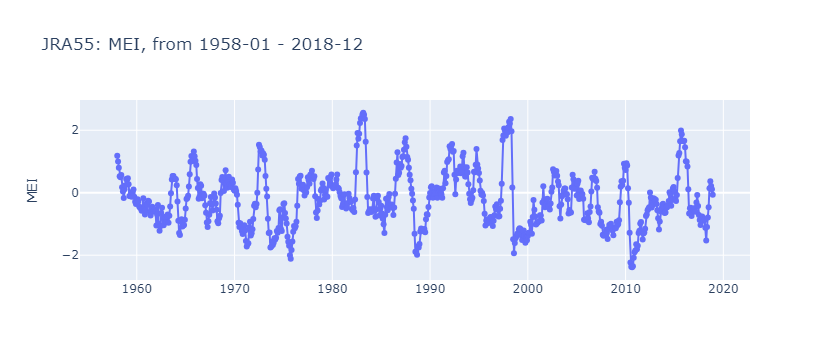

In [9]:
jra_55_mei_fig = go.Figure()
jra_55_mei_fig.add_trace(go.Scatter(x=jra55_df['date'], 
                                    y=jra55_df['mei'],
                                    mode='lines+markers',
                                    name='MEI'))
jra_55_mei_fig.update_layout(yaxis=dict(title="MEI"),
                             title=f"JRA55: MEI, from {jra55_df.iloc[0][0]} - {jra55_df.iloc[-1][0]}")
jra_55_mei_fig.show()

From the previous notebook, we've examed the ENSO factor MEI and see there is a recurring cycle that occurs every 3 to 7 years. In this report, we will create a customizsed log on MEI of 2, 8, and 11 to see their impacts.

In [19]:
# obtain Wheat SRW data
wb_sql_query = """
SELECT strftime('%Y-%m', MONTH) as date, 
    "Wheat, US SRW ($/mt) WHEAT_US_SRW" AS "WHEAT_US_SRW"
FROM cmo_historical_data_monthly
"""

wb_wheat = pd.read_sql_query(sql=wb_sql_query, con=db)
wb_wheat = wb_wheat.dropna(subset=['date'])
wb_wheat.dropna(inplace=True)  # drop empty WHEAT_US_SRW and log_SRW value due to no records present

In [12]:
# calculate the log return for time series analysis
def log_returns(prices: TIME_SERIES) -> SERIES:
    """
    Calculate log returns of a time series of prices.

    Args:
        prices (array-like): A time series of prices, such as stock prices or currency exchange rates.

    Returns:
        np.ndarray: An array of log returns.
    """
    prices_shifted = np.roll(prices, 1)
    log_returns = np.log(prices / prices_shifted)
    log_returns[0] = np.nan  # Set the first value to NaN, as there's no previous price to calculate the return

    return log_returns

In [16]:
wb_wheat.dropna()

date  WHEAT_US_SRW   log_SRW
229  1979-02       144.750  0.030691
230  1979-03       144.000 -0.005195
231  1979-04       142.250 -0.012227
232  1979-05       141.375 -0.006170
233  1979-06       163.875  0.147688
..       ...           ...       ...
717  2019-10       212.875  0.053056
718  2019-11       223.500  0.048706
719  2019-12       237.625  0.061282
720  2020-01       248.000  0.042735
721  2020-02       239.000 -0.036965

[493 rows x 3 columns]

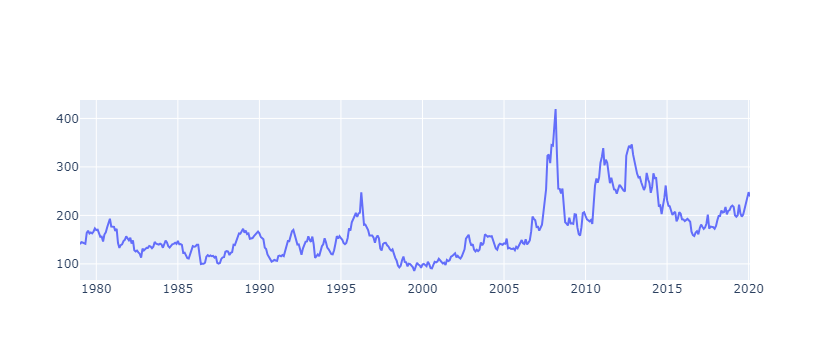

In [22]:
# plot the price trend from 1979-02 to 2020-02
go.Figure().add_trace(go.Scatter(x=wb_wheat.date,
                       y=wb_wheat.WHEAT_US_SRW,
                       name="log_return SRW"))

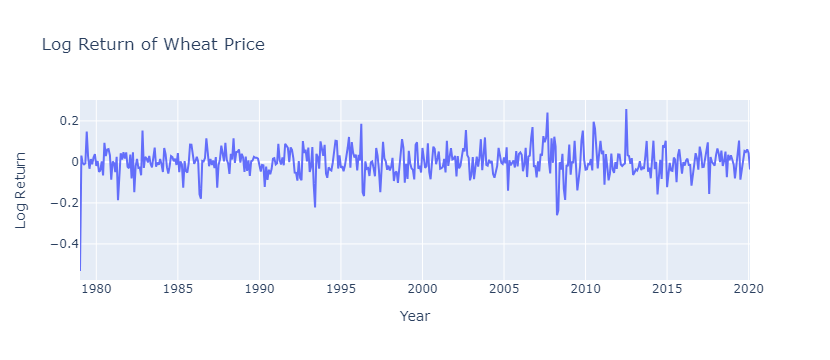

In [20]:
# calculate the log return
wb_wheat['log_SRW'] = log_returns(wb_wheat.WHEAT_US_SRW)

# plot the log return of wheat price
wb_log_return_fig = go.Figure()
wb_log_return_fig.add_trace(go.Scatter(x=wb_wheat.date,
                                       y=wb_wheat.log_SRW,
                                       name="log_return SRW"))
wb_log_return_fig.update_layout(yaxis=dict(title="Log Return"),
                                xaxis=dict(title="Year"),
                                title="Log Return of Wheat Price")
wb_log_return_fig.show()

The year 2008 had a significant impact on the price of the asset under consideration, leading to a sharp spike in prices during that year. Subsequently, the price stabilized around the $300 mark. However, these patterns are not as readily apparent when examining the log return plot, as the changes in log returns mostly fall within the range of -0.2 to 0.2.

To measure the effect of the ENSO (El Niño-Southern Oscillation) factor while eliminating external economic effects and focusing solely on the climate factor MEI (Multivariate ENSO Index), we need to conduct a controlled analysis using data from periods before 2008. This will allow us to isolate the impact of ENSO on the asset's price without interference from economic factors.

Based on the previous exploratory data analysis (EDA), it was observed that using only the single MEI (Multivariate ENSO Index) as a predictor did not perform well in predicting the asset's price behavior. However, when incorporating the entire JRA55 features, which likely include MEI along with other relevant climate factors like AO (Arctic Oscillation), IOD (Indian Ocean Dipole), PNA (Pacific-North American) indexes, etc., the overall autoregressive (AR) analysis showed better results. This pattern was also observed in the NNR1 dataset, where MEI's relationship with other climate factors influenced the predictive performance.

Now, the focus of this notebook is to refine the analysis specifically on the MEI by employing basis expansion techniques. The goal is to use customised log returns to recreate the results presented in Kitsios' study.

In [41]:
data = pd.merge(left=jra55_df, right=wb_wheat, left_on='date', right_on='date')
data.head()

date       mei  ao_index  iod_index  nhtele_index_1  nhtele_index_2  \
0  1979-01  0.297400 -1.782863   0.743508        1.654237       -1.220218   
1  1979-02  0.155501  0.908074   0.162428        1.720187       -0.613015   
2  1979-03 -0.216106 -0.905725   0.120236        0.193382        0.177883   
3  1979-04 -0.069926 -0.645040  -0.026113        1.457443       -1.099299   
4  1979-05  0.107746 -0.403216  -0.541475        0.237556        0.430475   

   nhtele_index_3  nhtele_index_4  pna_index  psa_index_1  psa_index_2  \
0       -0.015170       -0.127574  -0.093814    -0.062116    -0.098093   
1       -0.902236        0.208082  -2.331192    -0.092663     0.030918   
2        0.109086       -0.860008  -0.012094     0.441224    -0.442519   
3       -0.824337        0.832739  -0.586316     0.476121     0.265671   
4        1.181200       -2.577056   0.704884    -0.120438    -0.811983   

   sam_index  WHEAT_US_SRW   log_SRW  
0   0.361862       140.375 -0.532146  
1   0.471436       144.750  0.030691  
2   0.990468       144.000 -0.005195  
3   0.846673       142.250 -0.012227  
4   0.315965       141.375 -0.006170

## Define the Seasonal AR Model using MEI with lag 1 Data

In [87]:
# define the data with exogenous variable and lag 1
data['mei_l1'] = data['mei'].shift(1)
data['mei_l2'] = data['mei'].shift(2)
data['mei_l8'] = data['mei'].shift(8)
data['mei_l11'] = data['mei'].shift(11)
data.fillna(0, inplace=True)  # fill all missing value with 0
data.set_index('date', inplace=True)

In [47]:
# define the SARIMAX model with MEI as an exogenous variable and lag 1
order = (8, 2, 2)  # order and seasonal order parameters were explored in previous study
seasonal_order = (8, 1, 1, 12)

model = sm.tsa.SARIMAX(data['log_SRW'], exog=data['mei_l1'], 
                       order=order, seasonal_order=seasonal_order,
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
results = model.fit()

# print model summary
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.88753D-01    |proj g|=  3.62434D+00

At iterate    5    f= -6.71971D-01    |proj g|=  2.18870D-01

At iterate   10    f= -7.78654D-01    |proj g|=  9.60408D-01

At iterate   15    f= -8.26269D-01    |proj g|=  1.37151D+00

At iterate   20    f= -8.54324D-01    |proj g|=  7.72482D-01

At iterate   25    f= -8.83191D-01    |proj g|=  1.52480D+00

At iterate   30    f= -9.16822D-01    |proj g|=  2.23602D-01

At iterate   35    f= -9.33792D-01    |proj g|=  1.22105D-01

At iterate   40    f= -9.36441D-01    |proj g|=  9.60808D-02

At iterate   45    f= -9.38574D-01    |proj g|=  1.78588D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.41461D-01    |proj g|=  3.12509D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     58      1     0     0   3.125D-02  -9.415D-01
  F = -0.94146053915144401     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              log_SRW   No. Observations:                  480
Model:             SARIMAX(8, 2, 2)x(8, 1, [1], 12)   Log Likelihood                 451.901
Date:                              Wed, 26 Jul 2023   AIC                           -861.802
Time:                                      16:23:55   BIC                           -780.078
Sample:                                           0   HQIC                          -829.314
                                              - 480                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mei_l1        -0.0057      0.006     -0.941      0.347      -0.018       0.006
ar.L1         -0.8584      0.361     -2.376      0.017      -1.566      -0.150
ar.L2         -0.8147      0.267     -3.056      0.002      -1.337      -0.292
ar.L3         -0.6929      0.269     -2.573      0.010      -1.221      -0.165
ar.L4         -0.5719      0.227     -2.515      0.012      -1.018      -0.126
ar.L5         -0.3495      0.185     -1.892      0.059      -0.712       0.013
ar.L6         -0.2494      0.120     -2.073      0.038      -0.485      -0.014
ar.L7         -0.1612      0.087     -1.843      0.065      -0.333       0.010
ar.L8         -0.1418      0.054     -2.649      0.008      -0.247      -0.037
ma.L1         -0.8812      0.487     -1.810      0.070      -1.835       0.073
ma.L2         -0.1197      0.366     -0.327      0.744      -0.837       0.598
ar.S.L12      -0.9317      0.316     -2.947      0.003      -1.551      -0.312
ar.S.L24      -0.9368      0.322     -2.910      0.004      -1.568      -0.306
ar.S.L36      -0.8136      0.326     -2.493      0.013      -1.453      -0.174
ar.S.L48      -0.7133      0.286     -2.498      0.012      -1.273      -0.154
ar.S.L60      -0.5480      0.243     -2.254      0.024      -1.025      -0.071
ar.S.L72      -0.3994      0.185     -2.157      0.031      -0.762      -0.037
ar.S.L84      -0.2033      0.137     -1.481      0.139      -0.472       0.066
ar.S.L96      -0.0092      0.082     -0.112      0.911      -0.170       0.152
ma.S.L12      -0.0820      0.318     -0.258      0.797      -0.706       0.542
sigma2         0.0048      0.001      4.058      0.000       0.002       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                23.37
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.23
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Create Basis Expansion on MEI using Quadratic and Polynomial Features

In [48]:
from sklearn.preprocessing import PolynomialFeatures

In [49]:
# quadratic basis expansion
quad = PolynomialFeatures(degree=2, include_bias=False)
poly = PolynomialFeatures(degree=3, include_bias=False)

In [51]:
data_quad = quad.fit_transform(data['mei'].values.reshape(-1, 1))
data['mei_quad_1'] = data_quad[:, 0]
data['mei_quad_2'] = data_quad[:, 1]

In [53]:
data_ploy = poly.fit_transform(data['mei'].values.reshape(-1, 1))
data['mei_poly_1'] = data_ploy[:, 0]
data['mei_poly_2'] = data_ploy[:, 1]
data['mei_poly_3'] = data_ploy[:, 2]

## Create models for using customised Logs and Basis Expansion 

In [88]:
columns_to_use = ['log_SRW', 'mei', 
                  'mei_l1', 'mei_l2', 'mei_l8', 'mei_l11', 
                  'mei_quad_1', 'mei_quad_2', 
                  'mei_poly_1', 'mei_poly_2', 'mei_poly_3']
data_subset = data[columns_to_use].dropna()

In [124]:
def fit_seasonal_ar_model(endog, exog=None, order=(1, 0, 0), seasonal_order=(8, 1, 1, 12),
                          enforce_invertibility=True, enforce_stationarity=False):
    model = sm.tsa.SARIMAX(endog=endog, exog=exog, 
                           order=order, seasonal_order=seasonal_order,
                           enforce_invertibility=enforce_invertibility, 
                           enforce_stationarity=enforce_stationarity)
    return model

In [125]:
mei_quad_features = {'name': "quad_features", 'features': ['mei', 'mei_quad_1', 'mei_quad_2']}
mei_poly_features = {'name': "poly_features", 'features': ['mei', 'mei_poly_1', 'mei_poly_2', 'mei_poly_3']}
mei_lag_features = [{'name': "lag_feature_l1", 'features': ['mei_l1']},
                    {'name': "lag_feature_l2", 'features': ['mei_l2']},
                    {'name': "lag_feature_l8", 'features': ['mei_l8']},
                    {'name': "lag_feature_l11", 'features': ['mei_l11']}]

In [126]:
# initialize a dictionary to store the models
seasonal_ar_models = {}
data_subset.index.freq = 'M'

# loop through each feature space to fit the Seasonal AR models and store them in the dictionary
for feature_set in [mei_quad_features, mei_poly_features] + mei_lag_features:
    feature_name = feature_set['name']
    exog = data_subset[feature_set['features']]
    
    # split the data for training and testing (predicting)
    train_data = data_subset.loc[data_subset.index < '2007-01']
    test_data = data_subset.loc[data_subset.index >= '2007-01']
    
    # fit the model with training data
    model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_data[feature_set['features']])
    fitted_model = model.fit()  # Fit the model and get the fitted model
    
    # predict the next 12 months using the fitted model
    exog_future = test_data[feature_set['features']].loc['2007-01':'2007-12']  # Align exog with prediction period
    forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
    predicted_values = forecast
    
    # store the predicted values in the dictionary
    seasonal_ar_models[feature_name] = predicted_values

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.29667D-01    |proj g|=  3.95518D+00


 This problem is unconstrained.



At iterate    5    f= -9.80746D-01    |proj g|=  1.86432D-01

At iterate   10    f= -9.81894D-01    |proj g|=  4.03587D-02

At iterate   15    f= -9.82776D-01    |proj g|=  2.43162D-01

At iterate   20    f= -9.83068D-01    |proj g|=  7.18883D-02

At iterate   25    f= -9.83819D-01    |proj g|=  1.45590D-01

At iterate   30    f= -9.84005D-01    |proj g|=  1.46000D-01

At iterate   35    f= -9.84509D-01    |proj g|=  3.28845D-02

At iterate   40    f= -9.84949D-01    |proj g|=  2.29721D-01

At iterate   45    f= -9.85293D-01    |proj g|=  7.96071D-03


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.85358D-01    |proj g|=  5.63728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   5.637D-02  -9.854D-01
  F = -0.98535755472918518     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.29334D-01    |proj g|=  3.94279D+00

At iterate    5    f= -9.81670D-01    |proj g|=  2.37781D-01

At iterate   10    f= -9.82479D-01    |proj g|=  3.71848D-01

At iterate   15    f= -9.82972D-01    |proj g|=  4.46462D-02

At iterate   20    f= -9.83669D-01    |proj g|=  3.24605D-01

At iterate   25    f= -9.84131D-01    |proj g|=  8.54515D-02

At iterate   30    f= -9.84487D-01    |proj g|=  2.90958D-01

At iterate   35    f= -9.84830D-01    |proj g|=  1.93287D-02

At iterate   40    f= -9.85257D-01    |proj g|=  1.95715D-01

At iterate   45    f= -9.85654D-01    |proj g|=  4.75930D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.85811D-01    |proj g|=  2.65064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     61      1     0     0   2.651D-02  -9.858D-01
  F = -0.98581110945953909     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.28824D-01    |proj g|=  3.93551D+00

At iterate    5    f= -9.78177D-01    |proj g|=  7.81198D-02

At iterate   10    f= -9.79409D-01    |proj g|=  1.17126D-01

At iterate   15    f= -9.79654D-01    |proj g|=  2.56991D-01

At iterate   20    f= -9.80530D-01    |proj g|=  9.46001D-02

At iterate   25    f= -9.81077D-01    |proj g|=  9.00502D-02

At iterate   30    f= -9.81315D-01    |proj g|=  1.59848D-01

At iterate   35    f= -9.82018D-01    |proj g|=  1.53065D-01

At iterate   40    f= -9.82187D-01    |proj g|=  6.76291D-02

At iterate   45    f= -9.82260D-01    |proj g|=  3.24248D-03


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.82278D-01    |proj g|=  2.22468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.225D-02  -9.823D-01
  F = -0.98227848315865784     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.29373D-01    |proj g|=  3.94692D+00

At iterate    5    f= -9.79550D-01    |proj g|=  1.31833D-01

At iterate   10    f= -9.80903D-01    |proj g|=  1.10847D-01

At iterate   15    f= -9.81526D-01    |proj g|=  2.21899D-01

At iterate   20    f= -9.81970D-01    |proj g|=  2.62655D-01

At iterate   25    f= -9.82483D-01    |proj g|=  2.16080D-02

At iterate   30    f= -9.82841D-01    |proj g|=  2.16158D-01

At iterate   35    f= -9.83343D-01    |proj g|=  3.67111D-02

At iterate   40    f= -9.83540D-01    |proj g|=  7.12386D-02

At iterate   45    f= -9.83567D-01    |proj g|=  3.97968D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.83586D-01    |proj g|=  7.99763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   7.998D-03  -9.836D-01
  F = -0.98358560234926118     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.28751D-01    |proj g|=  3.91975D+00


 This problem is unconstrained.



At iterate    5    f= -9.77331D-01    |proj g|=  1.07995D-01

At iterate   10    f= -9.78991D-01    |proj g|=  1.18045D-01

At iterate   15    f= -9.79229D-01    |proj g|=  2.47647D-01

At iterate   20    f= -9.80264D-01    |proj g|=  1.91232D-01

At iterate   25    f= -9.80793D-01    |proj g|=  2.13449D-02

At iterate   30    f= -9.81721D-01    |proj g|=  2.72111D-02

At iterate   35    f= -9.81917D-01    |proj g|=  5.45365D-03

At iterate   40    f= -9.81965D-01    |proj g|=  1.52280D-02

At iterate   45    f= -9.81978D-01    |proj g|=  4.74349D-03


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.81997D-01    |proj g|=  2.01714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   2.017D-03  -9.820D-01
  F = -0.98199655251530249     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.29947D-01    |proj g|=  3.91155D+00

At iterate    5    f= -9.77710D-01    |proj g|=  1.05541D-01

At iterate   10    f= -9.79421D-01    |proj g|=  1.43967D-01

At iterate   15    f= -9.79691D-01    |proj g|=  2.53420D-01

At iterate   20    f= -9.80562D-01    |proj g|=  1.05360D-01

At iterate   25    f= -9.81242D-01    |proj g|=  5.47360D-02

At iterate   30    f= -9.81528D-01    |proj g|=  2.77076D-02

At iterate   35    f= -9.82437D-01    |proj g|=  3.98519D-02

At iterate   40    f= -9.82465D-01    |proj g|=  3.00965D-02

At iterate   45    f= -9.82518D-01    |proj g|=  1.18498D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.82528D-01    |proj g|=  1.08390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.084D-02  -9.825D-01
  F = -0.98252780391316941     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


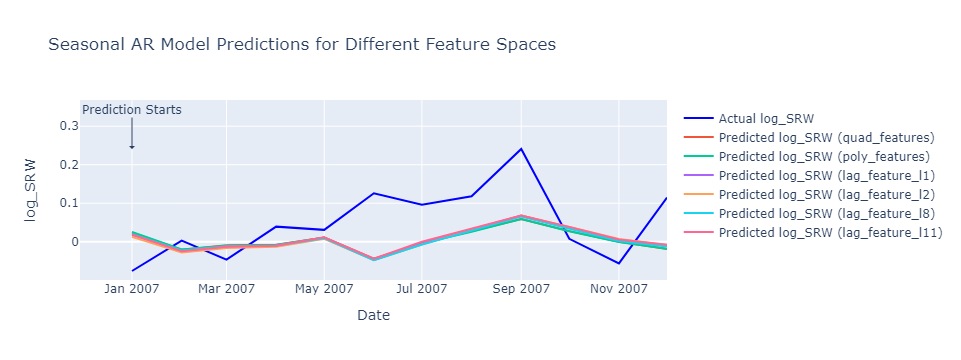

In [127]:
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12",'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Loop through each feature space and add the predicted values to the plot
for feature_name, predicted_values in seasonal_ar_models.items():
    fig.add_trace(go.Scatter(x=predicted_values.index, y=predicted_values,
                             mode='lines', name=f'Predicted log_SRW ({feature_name})'))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions for Different Feature Spaces",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

## Experiment

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.51807D-01    |proj g|=  3.49774D+00

At iterate    5    f= -9.22758D-01    |proj g|=  1.25902D-01

At iterate   10    f= -9.36510D-01    |proj g|=  1.01314D+00

At iterate   15    f= -9.44731D-01    |proj g|=  5.66621D-01

At iterate   20    f= -9.50560D-01    |proj g|=  6.84619D-02

At iterate   25    f= -9.53136D-01    |proj g|=  1.61688D-01

At iterate   30    f= -9.53976D-01    |proj g|=  1.38068D-01

At iterate   35    f= -9.54918D-01    |proj g|=  1.76949D-02

At iterate   40    f= -9.55500D-01    |proj g|=  4.89875D-02

At iterate   45    f= -9.55748D-01    |proj g|=  2.66931D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.56417D-01    |proj g|=  7.05968D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     57      1     0     0   7.060D-02  -9.564D-01
  F = -0.95641723210053253     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.50659D-01    |proj g|=  3.48569D+00

At iterate    5    f= -9.23735D-01    |proj g|=  5.01091D-01

At iterate   10    f= -9.31532D-01    |proj g|=  9.03598D-01

At iterate   15    f= -9.45434D-01    |proj g|=  3.06152D-01

At iterate   20    f= -9.50780D-01    |proj g|=  1.58496D-01

At iterate   25    f= -9.51516D-01    |proj g|=  1.37554D-01

At iterate   30    f= -9.53907D-01    |proj g|=  9.66662D-02

At iterate   35    f= -9.54375D-01    |proj g|=  1.56833D-01

At iterate   40    f= -9.55268D-01    |proj g|=  2.89275D-02

At iterate   45    f= -9.55674D-01    |proj g|=  9.14726D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -9.55756D-01    |proj g|=  1.92988D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     60      1     0     0   1.930D-01  -9.558D-01
  F = -0.95575573164002103     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


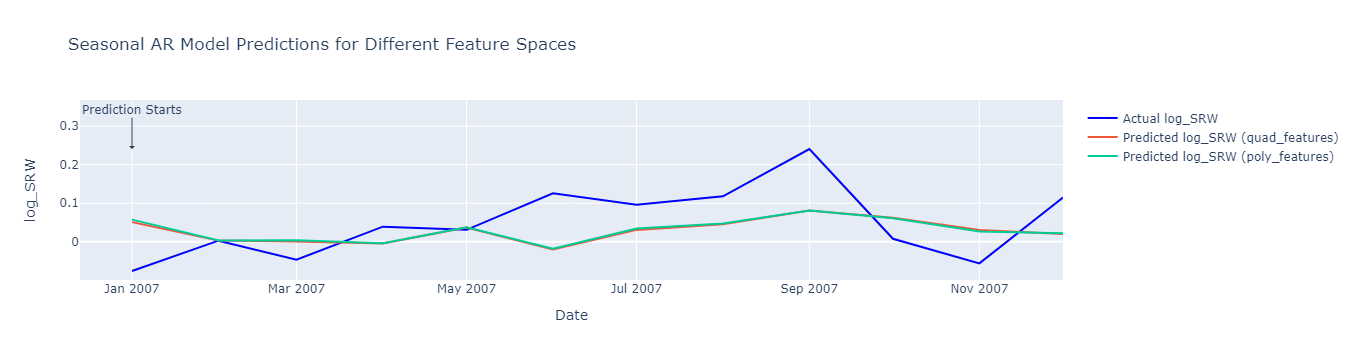

In [129]:
# initialize a dictionary to store the models
seasonal_ar_models = {}
data_subset.index.freq = 'M'

# loop through each feature space to fit the Seasonal AR models and store them in the dictionary
for feature_set in [mei_quad_features, mei_poly_features]:
    feature_name = feature_set['name']
    exog = data_subset[feature_set['features']]
    
    # split the data for training and testing (predicting)
    train_data = data_subset.loc[data_subset.index < '2007-01']
    test_data = data_subset.loc[data_subset.index >= '2007-01']
    
    # fit the model with training data
    model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_data[feature_set['features']], order=(8,1,2))
    fitted_model = model.fit()  # Fit the model and get the fitted model
    
    # predict the next 12 months using the fitted model
    exog_future = test_data[feature_set['features']].loc['2007-01':'2007-12']  # Align exog with prediction period
    forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
    predicted_values = forecast
    
    # store the predicted values in the dictionary
    seasonal_ar_models[feature_name] = predicted_values
    
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12",'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Loop through each feature space and add the predicted values to the plot
for feature_name, predicted_values in seasonal_ar_models.items():
    fig.add_trace(go.Scatter(x=predicted_values.index, y=predicted_values,
                             mode='lines', name=f'Predicted log_SRW ({feature_name})'))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions for Different Feature Spaces",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84884D-01    |proj g|=  8.50313D-01

At iterate    5    f= -5.82321D-01    |proj g|=  1.91832D-01

At iterate   10    f= -6.21694D-01    |proj g|=  1.26136D-01

At iterate   15    f= -7.07717D-01    |proj g|=  3.08452D-01

At iterate   20    f= -7.47561D-01    |proj g|=  8.99533D-02

At iterate   25    f= -7.66750D-01    |proj g|=  1.15938D-01

At iterate   30    f= -7.77080D-01    |proj g|=  8.60699D-02

At iterate   35    f= -7.86993D-01    |proj g|=  3.21291D-01

At iterate   40    f= -7.99948D-01    |proj g|=  2.06473D-01

At iterate   45    f= -8.14631D-01    |proj g|=  2.99709D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.35474D-01    |proj g|=  1.56136D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     57      1     0     0   1.561D-01  -8.355D-01
  F = -0.83547392639941653     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.26305D-01    |proj g|=  7.10801D-01


 This problem is unconstrained.



At iterate    5    f= -5.25831D-01    |proj g|=  9.16910D-01

At iterate   10    f= -5.98226D-01    |proj g|=  2.22060D-01

At iterate   15    f= -6.55242D-01    |proj g|=  1.19327D+00

At iterate   20    f= -7.05349D-01    |proj g|=  1.77729D+00

At iterate   25    f= -7.31688D-01    |proj g|=  9.25457D-01

At iterate   30    f= -7.52616D-01    |proj g|=  6.60683D-01

At iterate   35    f= -7.64028D-01    |proj g|=  2.54986D-01

At iterate   40    f= -7.73543D-01    |proj g|=  1.18821D-01

At iterate   45    f= -7.81130D-01    |proj g|=  1.34491D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -7.91951D-01    |proj g|=  2.21392D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     58      1     0     0   2.214D-01  -7.920D-01
  F = -0.79195099462947649     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


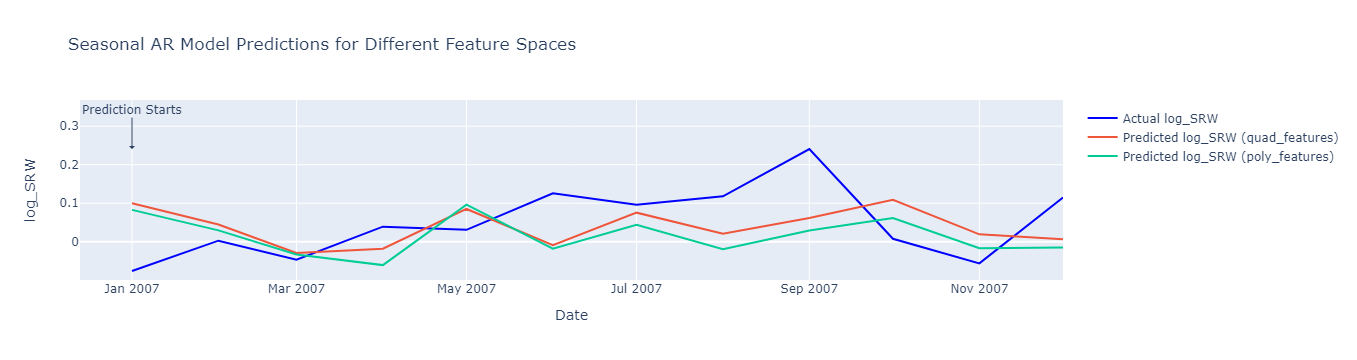

In [131]:
# initialize a dictionary to store the models
seasonal_ar_models = {}
data_subset.index.freq = 'M'

# loop through each feature space to fit the Seasonal AR models and store them in the dictionary
for feature_set in [mei_quad_features, mei_poly_features]:
    feature_name = feature_set['name']
    exog = data_subset[feature_set['features']]
    
    # split the data for training and testing (predicting)
    train_data = data_subset.loc[data_subset.index < '2007-01']
    test_data = data_subset.loc[data_subset.index >= '2007-01']
    
    # fit the model with training data
    model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_data[feature_set['features']], order=(8,2,3), seasonal_order=(6, 2, 1, 12))
    fitted_model = model.fit()  # Fit the model and get the fitted model
    
    # predict the next 12 months using the fitted model
    exog_future = test_data[feature_set['features']].loc['2007-01':'2007-12']  # Align exog with prediction period
    forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
    predicted_values = forecast
    
    # store the predicted values in the dictionary
    seasonal_ar_models[feature_name] = predicted_values
    
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12",'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Loop through each feature space and add the predicted values to the plot
for feature_name, predicted_values in seasonal_ar_models.items():
    fig.add_trace(go.Scatter(x=predicted_values.index, y=predicted_values,
                             mode='lines', name=f'Predicted log_SRW ({feature_name})'))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions for Different Feature Spaces",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84884D-01    |proj g|=  8.50313D-01

At iterate    5    f= -5.82321D-01    |proj g|=  1.91832D-01

At iterate   10    f= -6.21694D-01    |proj g|=  1.26136D-01

At iterate   15    f= -7.07717D-01    |proj g|=  3.08452D-01

At iterate   20    f= -7.47561D-01    |proj g|=  8.99533D-02

At iterate   25    f= -7.66750D-01    |proj g|=  1.15938D-01

At iterate   30    f= -7.77080D-01    |proj g|=  8.60699D-02

At iterate   35    f= -7.86993D-01    |proj g|=  3.21291D-01

At iterate   40    f= -7.99948D-01    |proj g|=  2.06473D-01

At iterate   45    f= -8.14631D-01    |proj g|=  2.99709D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.35474D-01    |proj g|=  1.56136D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     57      1     0     0   1.561D-01  -8.355D-01
  F = -0.83547392639941653     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.26305D-01    |proj g|=  7.10801D-01


 This problem is unconstrained.



At iterate    5    f= -5.25831D-01    |proj g|=  9.16910D-01

At iterate   10    f= -5.98226D-01    |proj g|=  2.22060D-01

At iterate   15    f= -6.55242D-01    |proj g|=  1.19327D+00

At iterate   20    f= -7.05349D-01    |proj g|=  1.77729D+00

At iterate   25    f= -7.31688D-01    |proj g|=  9.25457D-01

At iterate   30    f= -7.52616D-01    |proj g|=  6.60683D-01

At iterate   35    f= -7.64028D-01    |proj g|=  2.54986D-01

At iterate   40    f= -7.73543D-01    |proj g|=  1.18821D-01

At iterate   45    f= -7.81130D-01    |proj g|=  1.34491D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -7.91951D-01    |proj g|=  2.21392D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     58      1     0     0   2.214D-01  -7.920D-01
  F = -0.79195099462947649     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.80947D-01    |proj g|=  6.48094D-01

At iterate    5    f= -5.83443D-01    |proj g|=  1.66264D-01

At iterate   10    f= -6.30444D-01    |proj g|=  2.05817D-01

At iterate   15    f= -7.41808D-01    |proj g|=  4.25558D-01

At iterate   20    f= -7.69611D-01    |proj g|=  2.39661D-01

At iterate   25    f= -7.82768D-01    |proj g|=  7.62398D-01

At iterate   30    f= -8.06466D-01    |proj g|=  5.19823D-01

At iterate   35    f= -8.21355D-01    |proj g|=  1.12736D-01

At iterate   40    f= -8.38347D-01    |proj g|=  2.72649D-01

At iterate   45    f= -8.48853D-01    |proj g|=  1.25550D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.52603D-01    |proj g|=  1.12141D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   1.121D-01  -8.526D-01
  F = -0.85260334119046088     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.70873D-01    |proj g|=  6.65547D-01

At iterate    5    f= -5.77333D-01    |proj g|=  6.00790D-01

At iterate   10    f= -6.23843D-01    |proj g|=  2.98295D-01

At iterate   15    f= -7.36732D-01    |proj g|=  6.41818D-01

At iterate   20    f= -7.50629D-01    |proj g|=  4.58061D-01

At iterate   25    f= -7.65984D-01    |proj g|=  2.73032D-01

At iterate   30    f= -7.81444D-01    |proj g|=  1.14286D-01

At iterate   35    f= -8.09601D-01    |proj g|=  2.75749D-01

At iterate   40    f= -8.35598D-01    |proj g|=  8.35541D-02

At iterate   45    f= -8.51673D-01    |proj g|=  6.88629D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.55105D-01    |proj g|=  1.73185D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     56      1     0     0   1.732D-01  -8.551D-01
  F = -0.85510531255751387     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47007D-02    |proj g|=  3.89650D+00

At iterate    5    f= -3.75633D-01    |proj g|=  2.83558D+00

At iterate   10    f= -4.93874D-01    |proj g|=  6.03440D-01

At iterate   15    f= -6.40356D-01    |proj g|=  8.25415D-01

At iterate   20    f= -7.01524D-01    |proj g|=  2.55590D-01

At iterate   25    f= -7.35573D-01    |proj g|=  1.36568D-01

At iterate   30    f= -7.47114D-01    |proj g|=  1.54599D-01

At iterate   35    f= -7.55534D-01    |proj g|=  3.97932D-01

At iterate   40    f= -7.81918D-01    |proj g|=  3.90945D-01

At iterate   45    f= -8.13705D-01    |proj g|=  2.51730D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.22294D-01    |proj g|=  9.50168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   9.502D-02  -8.223D-01
  F = -0.82229350586710281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.38415D-01    |proj g|=  5.20373D-01

At iterate    5    f= -5.82454D-01    |proj g|=  4.89564D-01

At iterate   10    f= -6.47073D-01    |proj g|=  1.42584D-01

At iterate   15    f= -7.42317D-01    |proj g|=  1.85179D-01

At iterate   20    f= -7.61304D-01    |proj g|=  2.17880D-01

At iterate   25    f= -7.79161D-01    |proj g|=  3.69745D-01

At iterate   30    f= -7.97559D-01    |proj g|=  2.87593D-01

At iterate   35    f= -8.27717D-01    |proj g|=  1.18401D-01

At iterate   40    f= -8.47531D-01    |proj g|=  2.91523D-01

At iterate   45    f= -8.53408D-01    |proj g|=  4.25519D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.55062D-01    |proj g|=  4.46907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     62      1     0     0   4.469D-02  -8.551D-01
  F = -0.85506218403913281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


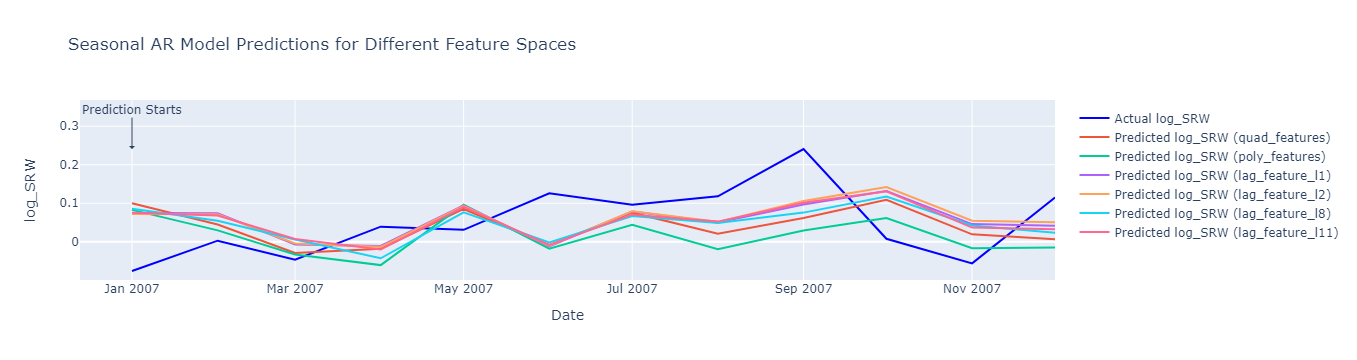

In [132]:
# initialize a dictionary to store the models
seasonal_ar_models = {}
data_subset.index.freq = 'M'

# loop through each feature space to fit the Seasonal AR models and store them in the dictionary
for feature_set in [mei_quad_features, mei_poly_features]  + mei_lag_features:
    feature_name = feature_set['name']
    exog = data_subset[feature_set['features']]
    
    # split the data for training and testing (predicting)
    train_data = data_subset.loc[data_subset.index < '2007-01']
    test_data = data_subset.loc[data_subset.index >= '2007-01']
    
    # fit the model with training data
    model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_data[feature_set['features']], order=(8,2,3), seasonal_order=(6, 2, 1, 12))
    fitted_model = model.fit()  # Fit the model and get the fitted model
    
    # predict the next 12 months using the fitted model
    exog_future = test_data[feature_set['features']].loc['2007-01':'2007-12']  # Align exog with prediction period
    forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
    predicted_values = forecast
    
    # store the predicted values in the dictionary
    seasonal_ar_models[feature_name] = predicted_values
    
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12",'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Loop through each feature space and add the predicted values to the plot
for feature_name, predicted_values in seasonal_ar_models.items():
    fig.add_trace(go.Scatter(x=predicted_values.index, y=predicted_values,
                             mode='lines', name=f'Predicted log_SRW ({feature_name})'))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions for Different Feature Spaces",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42793D-02    |proj g|=  1.98846D+00


 This problem is unconstrained.



At iterate    5    f= -4.03198D-01    |proj g|=  7.70068D-01

At iterate   10    f= -4.14885D-01    |proj g|=  5.81079D-01

At iterate   15    f= -4.22687D-01    |proj g|=  1.07948D+00
  ys=-8.989E-04  -gs= 1.032E-03 BFGS update SKIPPED

At iterate   20    f= -4.25689D-01    |proj g|=  5.92691D-01

At iterate   25    f= -4.27055D-01    |proj g|=  4.56606D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     27     84      1     1     0   7.403D-01  -4.271D-01
  F = -0.42705701915100647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32334D-02    |proj g|=  2.01205D+00

At iterate    5    f= -3.87512D-01    |proj g|=  6.82682D-01

At iterate   10    f= -4.20097D-01    |proj g|=  4.12096D-01

At iterate   15    f= -4.35460D-01    |proj g|=  5.15392D-01
  ys=-1.551E-04  -gs= 9.622E-03 BFGS update SKIPPED

At iterate   20    f= -4.48713D-01    |proj g|=  7.68443D-01

At iterate   25    f= -4.53488D-01    |proj g|=  1.13869D+00

At iterate   30    f= -4.59110D-01    |proj g|=  1.55127D+00

At iterate   35    f= -4.65589D-01    |proj g|=  1.59750D+00

At iterate   40    f= -4.76094D-01    |proj g|=  6.94773D-01

At iterate   45    f= -4.79584D-01    |proj g|=  4.57564D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -4.79765D-01    |proj g|=  5.87464D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50    117      1     1     0   5.875D-01  -4.798D-01
  F = -0.47976520783562038     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30778D-02    |proj g|=  2.13247D+00


 This problem is unconstrained.



At iterate    5    f= -3.88344D-01    |proj g|=  5.00888D-01

At iterate   10    f= -3.90736D-01    |proj g|=  1.01663D+00

At iterate   15    f= -4.09246D-01    |proj g|=  3.84347D-01

At iterate   20    f= -4.17452D-01    |proj g|=  1.12918D+00

At iterate   25    f= -4.23288D-01    |proj g|=  3.43457D-01

At iterate   30    f= -4.27990D-01    |proj g|=  5.60524D-01

At iterate   35    f= -4.34773D-01    |proj g|=  4.64530D-01

At iterate   40    f= -4.37846D-01    |proj g|=  7.57032D-01

At iterate   45    f= -4.39290D-01    |proj g|=  5.19225D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -4.46060D-01    |proj g|=  4.12991D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50    104      1     0     0   4.130D-01  -4.461D-01
  F = -0.44606036818080014     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.73123D-02    |proj g|=  2.07738D+00

At iterate    5    f= -3.86509D-01    |proj g|=  5.55610D-01

At iterate   10    f= -3.93486D-01    |proj g|=  1.10369D+00

At iterate   15    f= -3.96568D-01    |proj g|=  8.97806D-01

At iterate   20    f= -4.02306D-01    |proj g|=  7.45249D-01

At iterate   25    f= -4.13166D-01    |proj g|=  4.23785D-01

At iterate   30    f= -4.18166D-01    |proj g|=  9.41036D-01

At iterate   35    f= -4.23080D-01    |proj g|=  7.16845D-01

At iterate   40    f= -4.48156D-01    |proj g|=  8.67429D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     43    122      2     0     0   8.841D-01  -4.482D-01
  F = -0.44819318470165198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40185D-01    |proj g|=  1.08627D+00

At iterate    5    f= -2.92232D-01    |proj g|=  2.46490D+00

At iterate   10    f= -3.83050D-01    |proj g|=  8.73101D-01

At iterate   15    f= -4.28954D-01    |proj g|=  6.18070D-01

At iterate   20    f= -4.70622D-01    |proj g|=  5.74812D-01

At iterate   25    f= -4.97894D-01    |proj g|=  1.05762D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -5.04408D-01    |proj g|=  5.42645D-01

At iterate   35    f= -5.06135D-01    |proj g|=  3.65618D-01

At iterate   40    f= -5.09147D-01    |proj g|=  7.70796D-01
  ys=-4.418E-09  -gs= 9.187E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     43    160      3     1     0   8.562D-01  -5.092D-01
  F = -0.50915233997566423     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77755D-02    |proj g|=  2.00994D+00

At iterate    5    f= -3.88865D-01    |proj g|=  8.84573D-01

At iterate   10    f= -3.96164D-01    |proj g|=  4.22000D-01

At iterate   15    f= -4.08627D-01    |proj g|=  1.35192D+00

At iterate   20    f= -4.27489D-01    |proj g|=  5.95280D-01

At iterate   25    f= -4.32817D-01    |proj g|=  8.94749D-01

At iterate   30    f= -4.35102D-01    |proj g|=  7.87047D-01

At iterate   35    f= -4.35716D-01    |proj g|=  2.95195D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -4.39865D-01    |proj g|=  5.74404D-01

At iterate   45    f= -4.41494D-01    |proj g|=  4.68492D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -4.46382D-01    |proj g|=  5.25030D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50    131      2     0     0   5.250D-01  -4.464D-01
  F = -0.44638197879121611     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


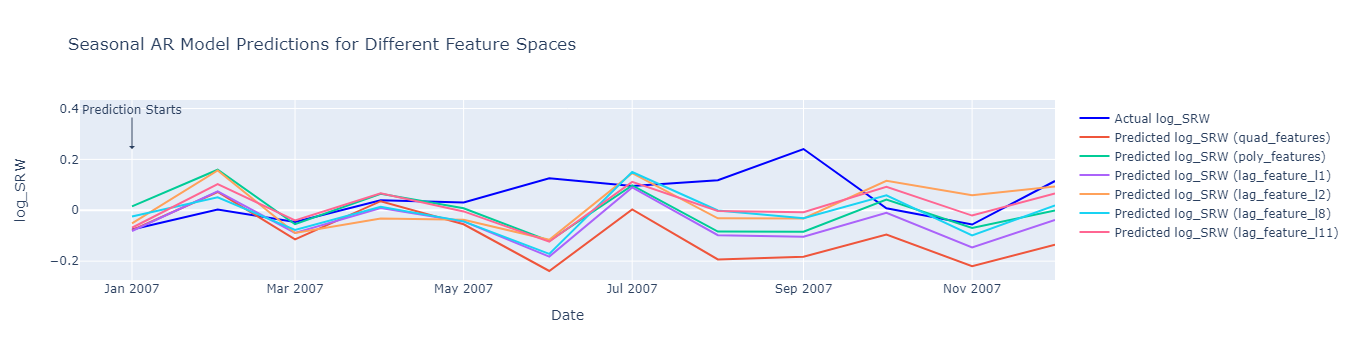

In [135]:
# initialize a dictionary to store the models
seasonal_ar_models = {}
data_subset.index.freq = 'M'

# loop through each feature space to fit the Seasonal AR models and store them in the dictionary
for feature_set in [mei_quad_features, mei_poly_features]  + mei_lag_features:
    feature_name = feature_set['name']
    exog = data_subset[feature_set['features']]
    
    # split the data for training and testing (predicting)
    train_data = data_subset.loc[data_subset.index < '2007-01']
    test_data = data_subset.loc[data_subset.index >= '2007-01']
    
    # fit the model with training data
    model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_data[feature_set['features']], order=(8,2,5), seasonal_order=(7, 3, 1, 12))
    fitted_model = model.fit()  # Fit the model and get the fitted model
    
    # predict the next 12 months using the fitted model
    exog_future = test_data[feature_set['features']].loc['2007-01':'2007-12']  # Align exog with prediction period
    forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
    predicted_values = forecast
    
    # store the predicted values in the dictionary
    seasonal_ar_models[feature_name] = predicted_values
    
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12",'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Loop through each feature space and add the predicted values to the plot
for feature_name, predicted_values in seasonal_ar_models.items():
    fig.add_trace(go.Scatter(x=predicted_values.index, y=predicted_values,
                             mode='lines', name=f'Predicted log_SRW ({feature_name})'))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions for Different Feature Spaces",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.04388D-01    |proj g|=  2.56696D+00

At iterate    5    f= -7.56438D-01    |proj g|=  2.84207D-01

At iterate   10    f= -7.71789D-01    |proj g|=  2.78448D-01

At iterate   15    f= -7.81896D-01    |proj g|=  2.14963D-01

At iterate   20    f= -7.91335D-01    |proj g|=  1.69089D-01

At iterate   25    f= -8.04752D-01    |proj g|=  3.54908D-01

At iterate   30    f= -8.08334D-01    |proj g|=  5.28934D-01

At iterate   35    f= -8.12448D-01    |proj g|=  1.80421D-01

At iterate   40    f= -8.17313D-01    |proj g|=  7.61652D-02

At iterate   45    f= -8.17972D-01    |proj g|=  1.10617D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.18536D-01    |proj g|=  1.86772D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     56      1     0     0   1.868D-01  -8.185D-01
  F = -0.81853582395096169     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93540D-01    |proj g|=  2.28451D+00


 This problem is unconstrained.



At iterate    5    f= -7.48900D-01    |proj g|=  1.51249D+00

At iterate   10    f= -7.66496D-01    |proj g|=  9.54735D-02

At iterate   15    f= -7.78676D-01    |proj g|=  1.22777D-01

At iterate   20    f= -7.85098D-01    |proj g|=  6.37770D-02

At iterate   25    f= -7.92927D-01    |proj g|=  1.51917D+00

At iterate   30    f= -7.98206D-01    |proj g|=  1.25001D-01

At iterate   35    f= -8.05739D-01    |proj g|=  1.88119D-01

At iterate   40    f= -8.06491D-01    |proj g|=  1.99921D-01

At iterate   45    f= -8.10087D-01    |proj g|=  3.69412D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.11688D-01    |proj g|=  5.16209D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     59      1     0     0   5.162D-02  -8.117D-01
  F = -0.81168817643616753     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.30521D-01    |proj g|=  2.76115D+00

At iterate    5    f= -7.80195D-01    |proj g|=  4.65292D-01

At iterate   10    f= -7.94107D-01    |proj g|=  2.12999D-01

At iterate   15    f= -8.02499D-01    |proj g|=  2.07413D-01

At iterate   20    f= -8.06457D-01    |proj g|=  8.66307D-02

At iterate   25    f= -8.11422D-01    |proj g|=  7.71051D-02

At iterate   30    f= -8.12655D-01    |proj g|=  7.78762D-02

At iterate   35    f= -8.13933D-01    |proj g|=  1.30531D-01

At iterate   40    f= -8.15342D-01    |proj g|=  6.92469D-02

At iterate   45    f= -8.15992D-01    |proj g|=  2.42350D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.16908D-01    |proj g|=  3.46145D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     59      1     0     0   3.461D-02  -8.169D-01
  F = -0.81690802274630481     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.46735D-01    |proj g|=  2.90075D+00


 This problem is unconstrained.



At iterate    5    f= -7.85946D-01    |proj g|=  3.65927D-01

At iterate   10    f= -7.99037D-01    |proj g|=  5.17262D-01

At iterate   15    f= -8.04305D-01    |proj g|=  2.67845D-01

At iterate   20    f= -8.07062D-01    |proj g|=  8.99606D-02

At iterate   25    f= -8.09753D-01    |proj g|=  5.14735D-02

At iterate   30    f= -8.11842D-01    |proj g|=  9.30454D-02

At iterate   35    f= -8.14514D-01    |proj g|=  1.74875D-01

At iterate   40    f= -8.16451D-01    |proj g|=  1.57586D-01

At iterate   45    f= -8.17812D-01    |proj g|=  1.42274D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.18195D-01    |proj g|=  2.12362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     58      1     0     0   2.124D-02  -8.182D-01
  F = -0.81819533738654726     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.23926D-01    |proj g|=  2.63209D+00

At iterate    5    f= -7.78675D-01    |proj g|=  6.95043D-01

At iterate   10    f= -7.89924D-01    |proj g|=  7.07300D-01

At iterate   15    f= -7.95581D-01    |proj g|=  1.32240D-01

At iterate   20    f= -8.02878D-01    |proj g|=  4.16667D-01

At iterate   25    f= -8.07333D-01    |proj g|=  8.60065D-02

At iterate   30    f= -8.11038D-01    |proj g|=  1.22104D-01

At iterate   35    f= -8.13810D-01    |proj g|=  3.03150D-02

At iterate   40    f= -8.16359D-01    |proj g|=  9.80913D-02

At iterate   45    f= -8.17486D-01    |proj g|=  6.27784D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.18718D-01    |proj g|=  5.69258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   5.693D-02  -8.187D-01
  F = -0.81871841363863851     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.30512D-01    |proj g|=  2.74462D+00


 This problem is unconstrained.



At iterate    5    f= -7.75395D-01    |proj g|=  3.55199D-01

At iterate   10    f= -7.89929D-01    |proj g|=  3.85360D-01

At iterate   15    f= -7.95917D-01    |proj g|=  5.83299D-01

At iterate   20    f= -7.99179D-01    |proj g|=  2.50335D-01

At iterate   25    f= -8.05155D-01    |proj g|=  8.87694D-02

At iterate   30    f= -8.08873D-01    |proj g|=  1.51490D-01

At iterate   35    f= -8.11495D-01    |proj g|=  2.36629D-01

At iterate   40    f= -8.12129D-01    |proj g|=  2.84403D-01

At iterate   45    f= -8.12427D-01    |proj g|=  8.70289D-02


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -8.13241D-01    |proj g|=  1.42300D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     64      1     0     0   1.423D-01  -8.132D-01
  F = -0.81324074345206099     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


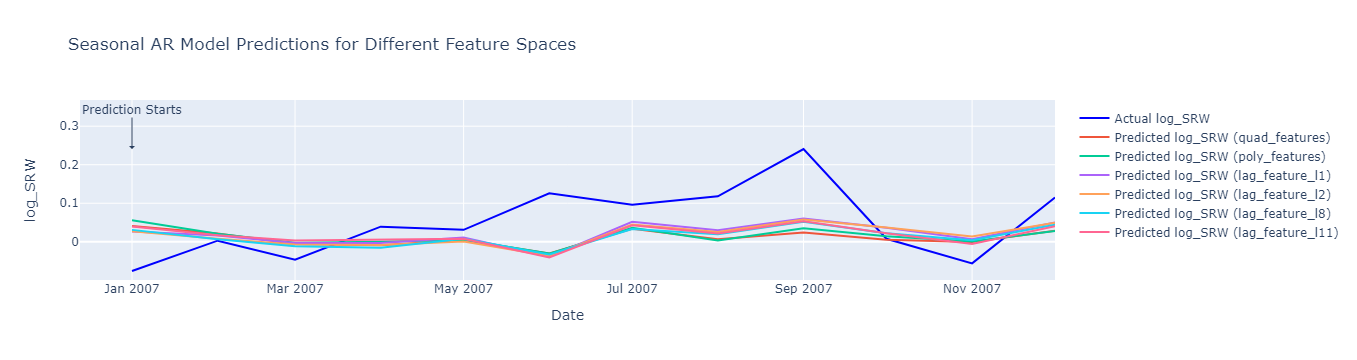

In [136]:
# initialize a dictionary to store the models
seasonal_ar_models = {}
data_subset.index.freq = 'M'

# loop through each feature space to fit the Seasonal AR models and store them in the dictionary
for feature_set in [mei_quad_features, mei_poly_features]  + mei_lag_features:
    feature_name = feature_set['name']
    exog = data_subset[feature_set['features']]
    
    # split the data for training and testing (predicting)
    train_data = data_subset.loc[data_subset.index < '2007-01']
    test_data = data_subset.loc[data_subset.index >= '2007-01']
    
    # fit the model with training data
    model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_data[feature_set['features']], order=(8,1,8), seasonal_order=(11, 1, 1, 12))
    fitted_model = model.fit()  # Fit the model and get the fitted model
    
    # predict the next 12 months using the fitted model
    exog_future = test_data[feature_set['features']].loc['2007-01':'2007-12']  # Align exog with prediction period
    forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
    predicted_values = forecast
    
    # store the predicted values in the dictionary
    seasonal_ar_models[feature_name] = predicted_values
    
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12",'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Loop through each feature space and add the predicted values to the plot
for feature_name, predicted_values in seasonal_ar_models.items():
    fig.add_trace(go.Scatter(x=predicted_values.index, y=predicted_values,
                             mode='lines', name=f'Predicted log_SRW ({feature_name})'))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions for Different Feature Spaces",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66434D-01    |proj g|=  9.28629D-01

At iterate    5    f= -1.52645D-01    |proj g|=  1.85123D+00

At iterate   10    f= -3.42877D-01    |proj g|=  1.37677D+00

At iterate   15    f= -4.41786D-01    |proj g|=  7.73892D-01

At iterate   20    f= -4.79849D-01    |proj g|=  7.67308D-01

At iterate   25    f= -5.04173D-01    |proj g|=  1.56454D+00

At iterate   30    f= -5.11743D-01    |proj g|=  7.28804D-01

At iterate   35    f= -5.16019D-01    |proj g|=  5.89866D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -5.24522D-01    |proj g|=  4.59923D-01

At iterate   45    f= -5.25830D-01    |proj g|=  6.98423D-01


/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f= -5.27015D-01    |proj g|=  8.98676D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50    132      3     0     0   8.987D-01  -5.270D-01
  F = -0.52701471911376785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


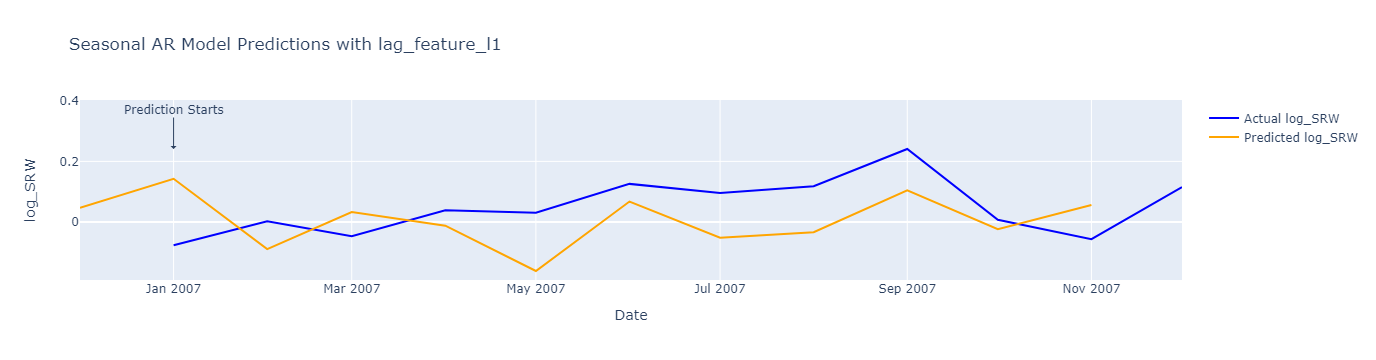

In [156]:
# Combine all the lag_feature_l1 columns into a single DataFrame
exog = data_subset[['mei_l1', 'mei_l2', 'mei_l8', 'mei_l11']]

# Split the data for training and testing (predicting)
train_data = data_subset.loc[data_subset.index < '2007-01']
train_exog = exog.loc[train_data.index]
test_data = data_subset.loc[data_subset.index >= '2007-01']
test_exog = exog.loc[test_data.index]

# Fit the model with training data
model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_exog, order=(8, 2, 5), seasonal_order=(7, 3, 1, 12))
fitted_model = model.fit()  # Fit the model and get the fitted model

# Predict the next 12 months using the fitted model
exog_future = test_exog.loc['2007-01':'2007-12']  # Align exog with prediction period
forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
predicted_values = forecast

# Plot the single model result using the custom function
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12", 'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Shift the index of the predicted values by one month (shift backward)
shifted_index = predicted_values.index - pd.DateOffset(months=1)
shifted_values = predicted_values.copy()
shifted_values.index = shifted_index

# Add the predicted log_SRW values to the plot
fig.add_trace(go.Scatter(x=shifted_values.index, y=shifted_values,
                         mode='lines', name='Predicted log_SRW', line=dict(color='orange')))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions with lag_feature_l1",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/rin/miniconda3/envs/mds-g36/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


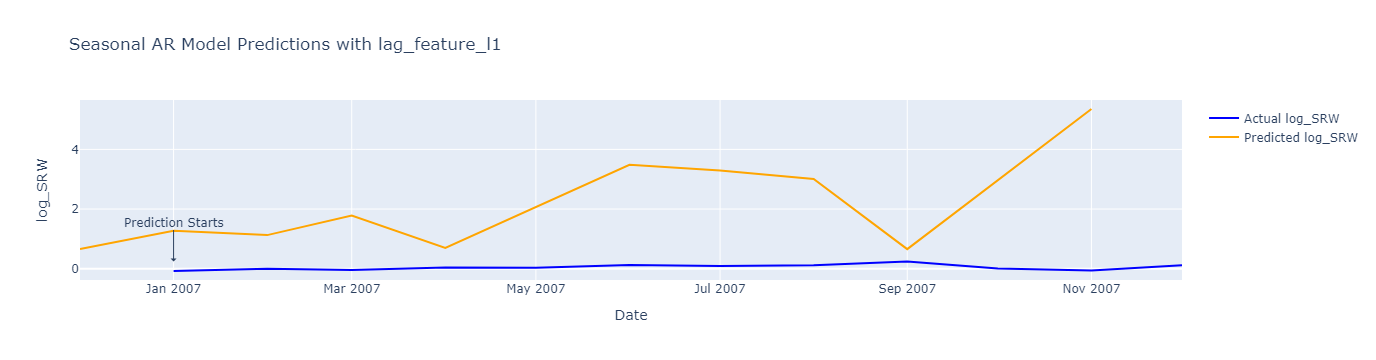

In [157]:
# Combine all the lag_feature_l1 columns into a single DataFrame
exog = data_subset[['mei_l1', 'mei_l2', 'mei_l8', 'mei_l11']]

# Split the data for training and testing (predicting)
train_data = data_subset.loc['2000-01':'2006-12']
train_exog = exog.loc[train_data.index]
test_data = data_subset.loc[data_subset.index > '2006-12']
test_exog = exog.loc[test_data.index]

# Fit the model with training data
model = fit_seasonal_ar_model(train_data['log_SRW'], exog=train_exog, order=(8, 2, 5), seasonal_order=(7, 3, 1, 12))
fitted_model = model.fit()  # Fit the model and get the fitted model

# Predict the next 12 months using the fitted model
exog_future = test_exog.loc['2007-01':'2007-12']  # Align exog with prediction period
forecast = fitted_model.predict(start="2007-01", end="2007-12", exog=exog_future)
predicted_values = forecast

# Plot the single model result using the custom function
fig = go.Figure()

# Filter actual log_SRW values for the testing period (2006-2008)
actual_values = test_data.loc[:"2007-12", 'log_SRW']

# Add the actual log_SRW values for the testing period
fig.add_trace(go.Scatter(x=actual_values.index, y=actual_values,
                         mode='lines', name='Actual log_SRW', line=dict(color='blue')))

# Shift the index of the predicted values by one month (shift backward)
shifted_index = predicted_values.index - pd.DateOffset(months=1)
shifted_values = predicted_values.copy()
shifted_values.index = shifted_index

# Add the predicted log_SRW values to the plot
fig.add_trace(go.Scatter(x=shifted_values.index, y=shifted_values,
                         mode='lines', name='Predicted log_SRW', line=dict(color='orange')))

# Update layout and add annotations
fig.update_layout(title="Seasonal AR Model Predictions with lag_feature_l1",
                  xaxis_title="Date", yaxis_title="log_SRW",
                  legend=dict(x=1.02, y=0.98),  # Position legend on the right side
                  annotations=[dict(x='2007-01-01', y=actual_values.max(),
                                    xref='x', yref='y',
                                    showarrow=True, arrowhead=1, ax=0, ay=-40,
                                    text="Prediction Starts")])

# Show the plot
fig.show()

- In this notebook, the objective was to improve the predictive power of an AR model for wheat log return using only a single exogenous factor - the MEI (El Niño Southern Oscillation). This was a deviation from previous studies that indicated adding more features from JRA55 would improve prediction results.
- The time period for the data used in the model was between 2000 and 2006, and predictions were made for the year 2007. The model did not incorporate any economic indicators or major economic event data.
- The MEI factor's dimensionality was increased using basis expansion methods such as quadratic and polynomial transformations. Furthermore, custom lags at periods of 1, 2, 8, and 11 months were experimented with.
- When the model used only a 1-month lag by default, the prediction results were subpar. However, a noticeable trend was observed.
- The results did not vary significantly when different features were used, whether they were from basis expansion or custom lags.
- Adjusting the seasonal factors in the model to have an 8-month lag and a 7-month seasonal lag with a 12-month cycle improved the predictions. In this case, the model with lags 2 and 11 showed results closer to the actual values compared to other models.
- Incorporating features at lags 1, 2, 8, and 11 as exogenous features and using one year of training data led to a reasonably accurate trend in the predictions.
- However, using the same set of lags (1, 2, 8, 11) as exogenous features but extending the training period from 2000 led to significant fluctuations in the model's predictions, which were far from satisfactory.
- Based on these observations, it seems that the lags at 2 and 11 months on MEI might be important for commodity price prediction, particularly for wheat SRW. Furthermore, predictions might be more accurate if major economic factors are excluded, and if the historical data used for training is limited to the past year.